# Sarcasm Detection with Bidirectional LSTM

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers,Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Read 'Data.csv'

In [2]:
df = pd.read_csv('Data.csv')

In [3]:
df.head()

,headlines,target
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic
4,God Urges Rick Perry Not To Run For President,Sarcastic


### Print some of the Headlines along with the target

In [4]:
for i in range(10):
    print(df['headlines'][i],'--->',df['target'][i])
    print()

CNN Triumphs (At Least in Most Demographic Categories) ---> Non Sarcastic

‘You Did The Best You Could,’ Says Iron Man Action Figure Voiced By Despondent Toys ‘R’ Us CEO Packing Up Office ---> Sarcastic

New Emails Reveal Warm Relationship Between Kamala Harris And Big Tech ---> Non Sarcastic

Donald Trump Jr. Gets Slammed Over Racist Birtherism Bot Attack On Kamala Harris ---> Non Sarcastic

God Urges Rick Perry Not To Run For President ---> Sarcastic

Global Aid Pours into Haiti ---> Non Sarcastic

CNN Anchor Calls Obama Protester 'Rude' And 'Crazy' ---> Non Sarcastic

Federal Prisons Reinstitute Executions By Lethal Inflation ---> Sarcastic

Lou Dobbs Crumbles When Pressed On His 'NAFTA Super Highway' Myth ---> Non Sarcastic

CNN Still Bent On Debating 'Two Sides' Of The Confederacy ---> Non Sarcastic



### Check Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12506 entries, 0 to 12505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  12506 non-null  object
 1   target     12506 non-null  object
dtypes: object(2)
memory usage: 195.5+ KB


### View basic statistical information about the dataset

In [6]:
df.describe()

,headlines,target
count,12506,12506
unique,12506,2
top,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
freq,1,6531


### Check for missing values

In [7]:
df.isna().sum()

headlines    0
target       0
dtype: int64

### Check for duplicates

In [8]:
df.duplicated().sum()

0

### Plot a countplot of the Class Index

<Axes: xlabel='count', ylabel='target'>

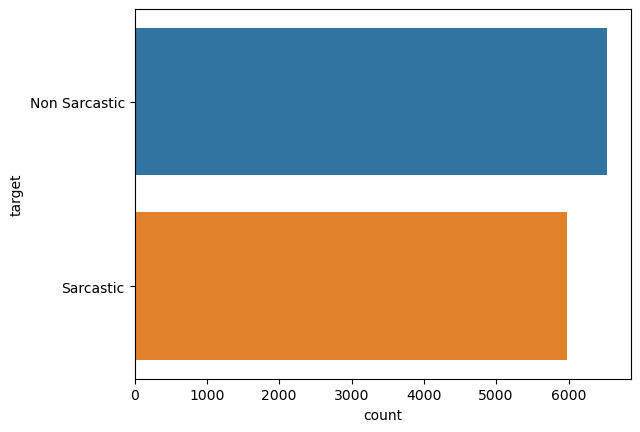

In [9]:
sns.countplot(y=df['target'])

### Create a funciton to preprocess the text

In [10]:
def preprocess(sentence):
    sentence = sentence.lower()
    text = re.sub(r"[^0-9a-zA-Z]",' ',sentence).split()
    
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(i) for i in text]
    
    return " ".join(text)

### Apply the preprocess function to the description

In [11]:
df['headlines'] = df['headlines'].apply(preprocess)

In [12]:
for i in range(10):
    print(df['headlines'][i],'--->',df['target'][i])
    print()

cnn triumph at least in most demographic category ---> Non Sarcastic

you did the best you could say iron man action figure voiced by despondent toy r u ceo packing up office ---> Sarcastic

new email reveal warm relationship between kamala harris and big tech ---> Non Sarcastic

donald trump jr get slammed over racist birtherism bot attack on kamala harris ---> Non Sarcastic

god urge rick perry not to run for president ---> Sarcastic

global aid pours into haiti ---> Non Sarcastic

cnn anchor call obama protester rude and crazy ---> Non Sarcastic

federal prison reinstitute execution by lethal inflation ---> Sarcastic

lou dobbs crumbles when pressed on his nafta super highway myth ---> Non Sarcastic

cnn still bent on debating two side of the confederacy ---> Non Sarcastic



### Split Input & Target Variables

In [62]:
x = df['headlines']
y = df['target']

### One Hot encode our Target Variable

In [63]:
y.unique()

array(['Non Sarcastic', 'Sarcastic'], dtype=object)

In [64]:
from sklearn.preprocessing import LabelBinarizer

In [65]:
encoder=LabelBinarizer()

In [66]:
y=encoder.fit_transform(y)

In [67]:
y

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

### Split the dataset into Training & Testing Set

In [68]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=100)

### Create a keras Tokenizer object

In the Keras library, the Tokenizer is a class that can be used to preprocess text data. It allows you to convert a collection of text documents into a numerical representation that can be used as input to a machine learning model.

In [69]:
tokenizer = Tokenizer(num_words=5000)

### fit on text for our X

In [70]:
tokenizer.fit_on_texts(x)

In [71]:
vocab_size = len(tokenizer.word_index)+1

### Create a function to convert text to numerical representation and add padding

In [72]:
def text_encoding(txt):
    encoded_doc = tokenizer.texts_to_sequences(txt)
    
    padded_sequence = pad_sequences(encoded_doc,maxlen=128)
    
    return padded_sequence

### Apply the function to our X_train & X_test

In [73]:
x_train = text_encoding(x_train)
x_test = text_encoding(x_test)

In [74]:
x_train

array([[   0,    0,    0, ...,    6, 1462,   66],
       [   0,    0,    0, ...,  111,    6,  256],
       [   0,    0,    0, ...,  155,   33,  480],
       ...,
       [   0,    0,    0, ..., 2601,    4,  860],
       [   0,    0,    0, ...,    4, 1508,  225],
       [   0,    0,    0, ...,  107,  767, 4599]])

### Create keras Sequential model with GRU Layers

In [75]:
sequence_lengths = [len(sequence) for sequence in x_train]
print("Average length:", sum(sequence_lengths) / len(sequence_lengths))
print("Max length:", max(sequence_lengths))

Average length: 128.0
Max length: 128


In [90]:
model = Sequential()

#model.add(layers.Embedding(vocab_size,128))
model.add(layers.Embedding(vocab_size, 128, input_shape=(128,)))

model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
model.add(layers.Dropout(0.2))

model.add(layers.Bidirectional(layers.GRU(128)))
model.add(layers.Dense(64,activation='sigmoid'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

C:\Users\shrid\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 128, 128)            │       1,972,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128, 256)            │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,483,713 (9.47 MB)

 Trainable params: 2,483,713 (9.47 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [92]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Train the model with our Training Set

In [93]:
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.05)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.7397 - loss: 0.4652 - val_accuracy: 0.8942 - val_loss: 0.2398
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.9489 - loss: 0.1481 - val_accuracy: 0.9062 - val_loss: 0.2414
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.9770 - loss: 0.0771 - val_accuracy: 0.9142 - val_loss: 0.2788
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.9881 - loss: 0.0400 - val_accuracy: 0.8882 - val_loss: 0.3418
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.9897 - loss: 0.0358 - val_accuracy: 0.8383 - val_loss: 0.4484
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 51s 173ms/step - accuracy: 0.9742 - loss: 0.0691 - val_accuracy: 0.8822 - val_loss: 0.4133
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.9951 - loss: 0.0214 - val_accuracy: 0.8882 - val_loss: 0.4235
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.9962 - loss: 0

### Make predictions with Test set

In [94]:
y_pred = model.predict(x_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


In [97]:
y_pred

array([[6.3138254e-02],
       [9.9889159e-01],
       [9.9915040e-01],
       ...,
       [7.9616107e-04],
       [6.5236790e-03],
       [8.3145360e-04]], dtype=float32)

In [98]:
y_pred = [np.argmax(i) for i in y_pred]

### Check accuracy score

In [100]:
accuracy_score(y_test,y_pred_binary)

0.8784972022382095

### Confusion matrix

<Axes: >

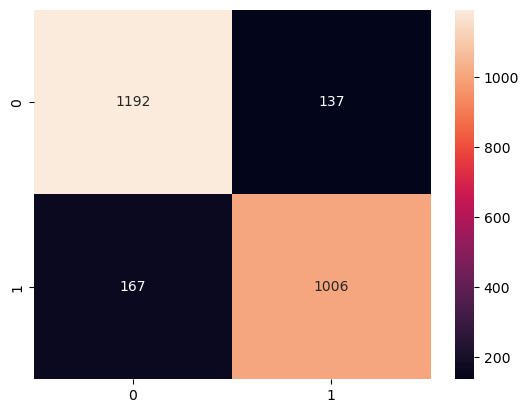

In [103]:
sns.heatmap(confusion_matrix(y_test,y_pred_binary),annot=True,fmt='d')

### Classification Report

In [104]:
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1329
           1       0.88      0.86      0.87      1173

    accuracy                           0.88      2502
   macro avg       0.88      0.88      0.88      2502
weighted avg       0.88      0.88      0.88      2502



***